In [180]:
import sys
sys.path.append("./lib")
import numpy as np
import pymaster as nmt 
import pysm3
import time
from mpfit import mpfit
import mpfitlib as mpl
import scipy
#from Nearest_Positive_Definite import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patheffects as path_effects
import scipy.stats as st
import basicfunc as func
import analys_lib as an
from plotlib import plotr_gaussproduct
import matplotlib.pyplot as plt 

r=0.
nside = 64
lmax = nside*3-1
#lmax=850
scale = 10
Nlbin = 10
fsky = 0.7
ELLBOUND = 15
dusttype = 1
synctype = 1
kw=''
kwsim=''
Pathload='./'
instr_name='litebird_full'
instr =  np.load("./lib/instr_dict/%s.npy"%instr_name,allow_pickle=True).item()
freq= instr['frequencies']
N_freqs =len(freq)
Ncross=int(N_freqs*(N_freqs+1)/2)
sens_P= instr['sens_P']
sigpix= sens_P/(np.sqrt((4*np.pi)/Npix*(60*180/np.pi)**2))
b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()
nucross = []
for i in range(0,N_freqs):
    for j in range(i,N_freqs):
        nucross.append(np.sqrt(freq[i]*freq[j]))
nucross = np.array(nucross)


In [181]:
DLd0s0 = np.load(Pathload+"/CLsimus/DLcross_nside%s_fsky%s_scale%s_Nlbin%s_d%ss%sc.npy"%(nside,fsky,scale,Nlbin,0,0))
DLd1s1 = np.load(Pathload+"/CLsimus/DLcross_nside%s_fsky%s_scale%s_Nlbin%s_d%ss%sc.npy"%(nside,fsky,scale,Nlbin,1,1))
DLdbsb = np.load(Pathload+"/CLsimus/DLcross_nside%s_fsky%s_scale%s_Nlbin%s_d%ss%sc.npy"%(nside,fsky,scale,Nlbin,'b','b'))

DL_cmb = np.load(Pathload+"/CLsimus/DLcross_nside%s_fsky%s_scale%s_Nlbin%s_c.npy"%(nside,fsky,scale,Nlbin))
CLcmb_or=hp.read_cl('./CLsimus/Cls_Planck2018_r0.fits') #TT EE BB TE
DL_lens = l*(l+1)*b.bin_cell(CLcmb_or[2,2:lmax+3])/2/np.pi

In [182]:
def plotDL(DL,l):
    c=["darkblue",'forestgreen',"darkorange","darkviolet","darkred"]
    font = {'size': 65}
    matplotlib.rc('font', **font)

    cmap   = plt.get_cmap('jet_r',402) #color map parameter
    plt.figure(figsize=(35,20))
    DL_mean=np.mean(DL, axis=0)
    DL_std=np.std(DL, axis=0)

    for i,f in enumerate(np.linspace(0,Ncross-1,Ncross)):
             plt.errorbar(l,DL_mean[int(f)],yerr=DL_std[int(f)],fmt='.',color=cmap((int(nucross[i]))),markersize=20)#,label='%s'%f)
    plt.loglog()
    plt.plot(l, DL_lens, color='black', linestyle = '--', lw=5, label='lensing',zorder=90)
    sm   = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=45,vmax=0))
    sm.set_array([])
    tick = 45/3
    cbar = plt.colorbar(sm, ticks=[0,tick,2*tick,3*tick])
    cbar.ax.set_yticklabels([nucross[0],np.rint(nucross[int(Ncross/3)]),np.rint(nucross[int(2*Ncross/3)]),nucross[Ncross-1]])
    cbar.set_label(r"$\sqrt{\nu_{i} \times \nu_{j}} \,\, [{\rm GHz}]$",labelpad=30)
    plt.ylabel(r"$\mathcal{D}_\ell(\nu_i \times \nu_j) \, \,  [\mu \,{\rm K}_{\rm CMB}^2]$",labelpad=56)
    plt.xlabel(r'$\ell$')
    #plt.xlim([10,205])
    plt.show()


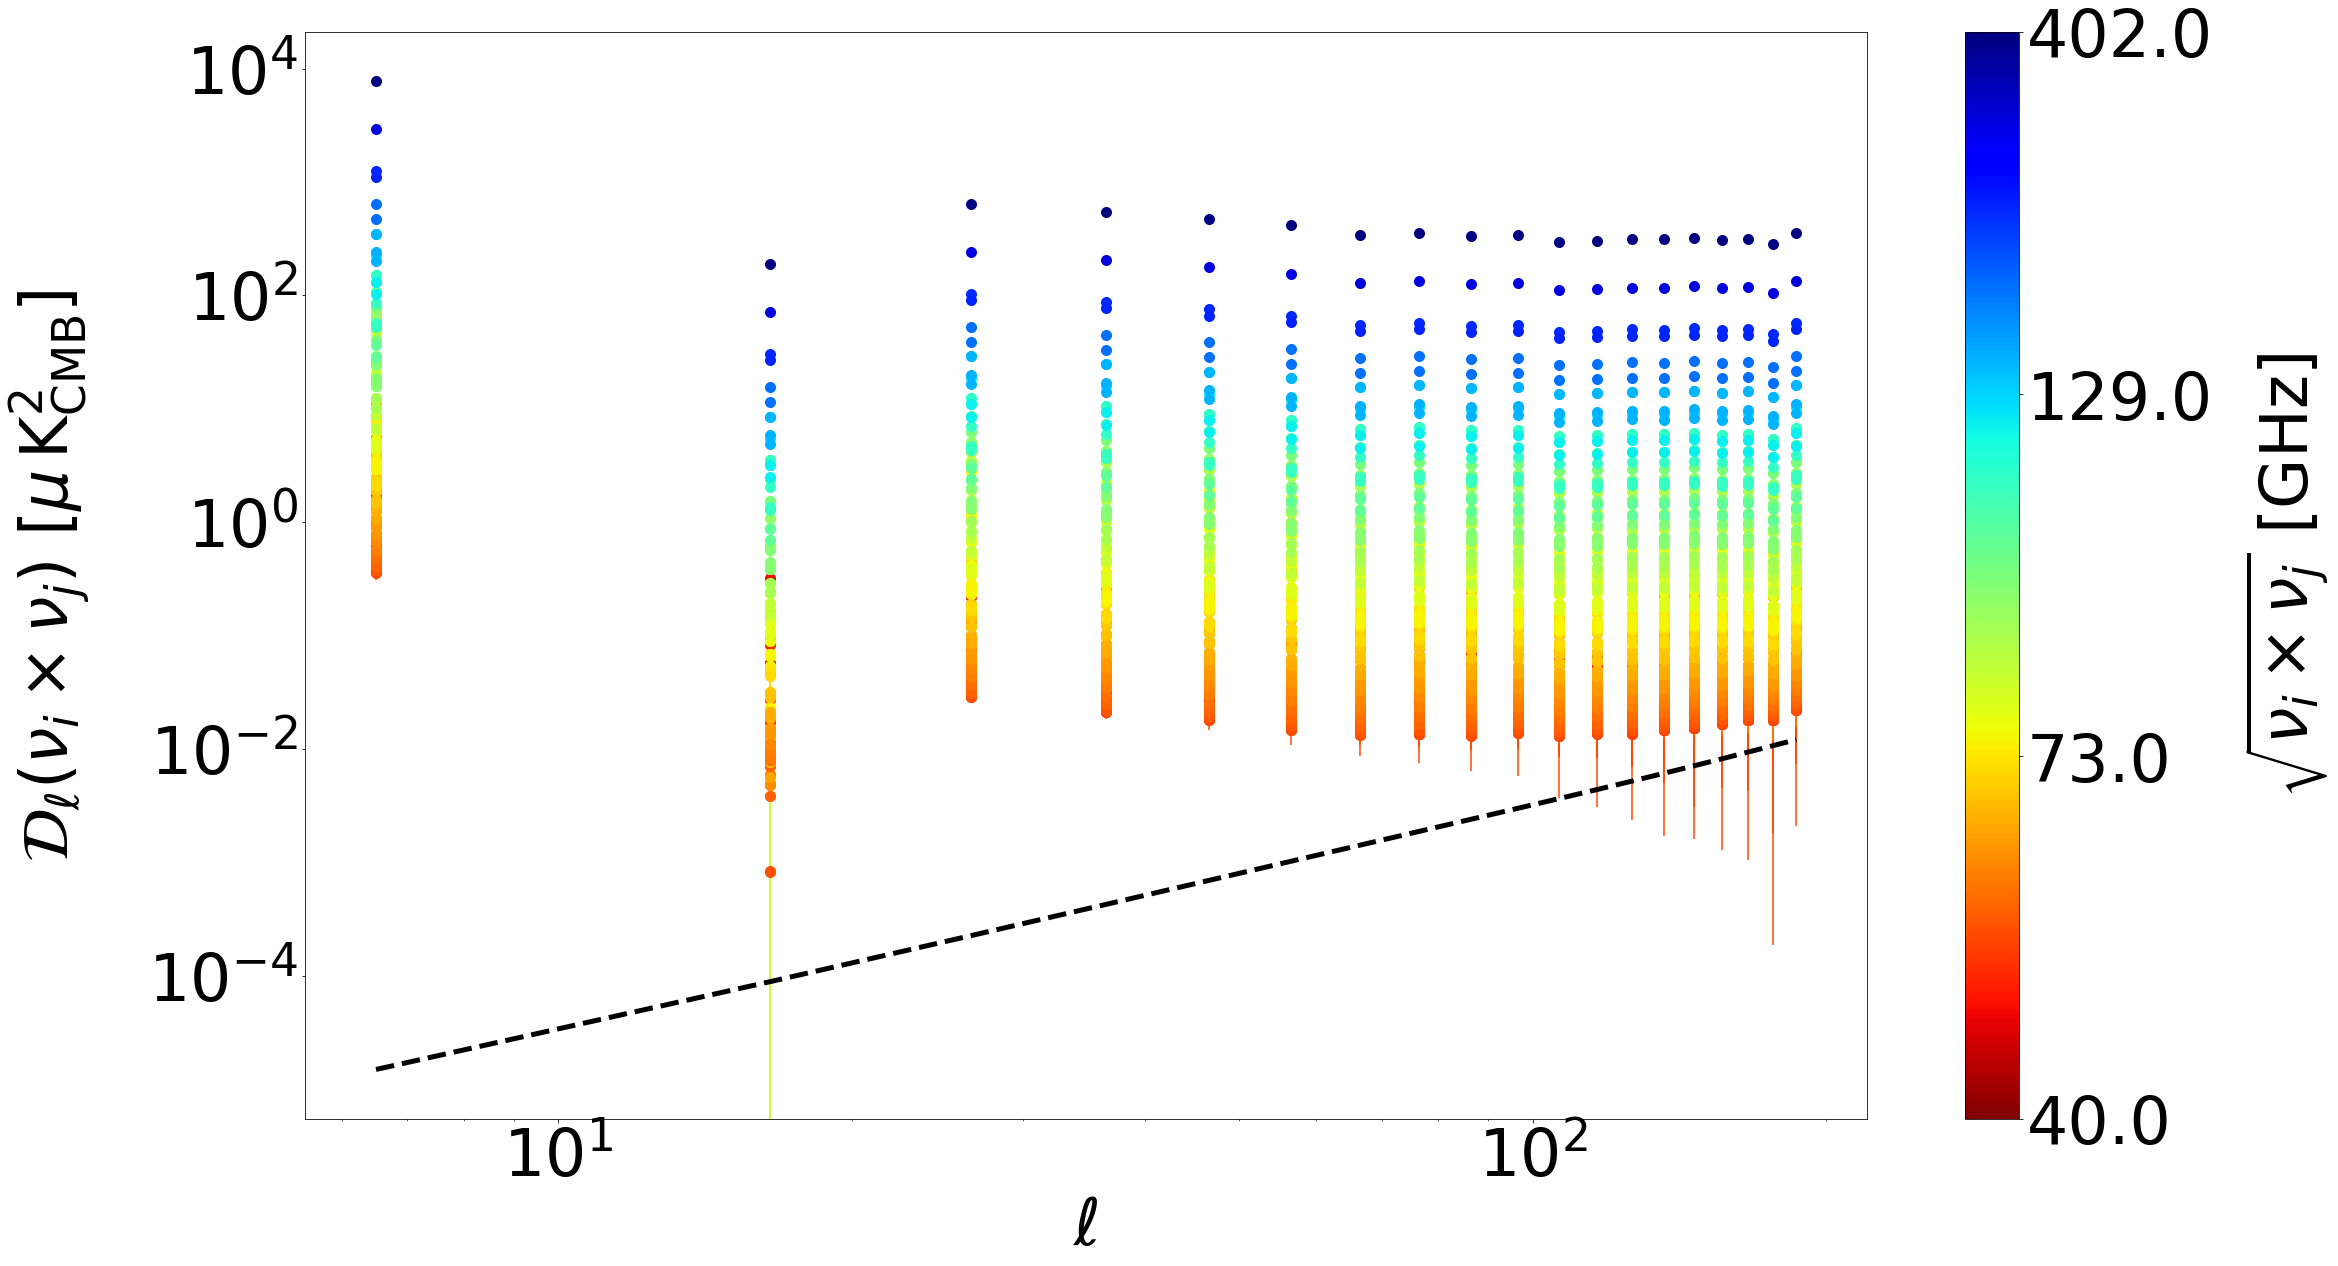

In [183]:
plotDL(DLd0s0,leff)

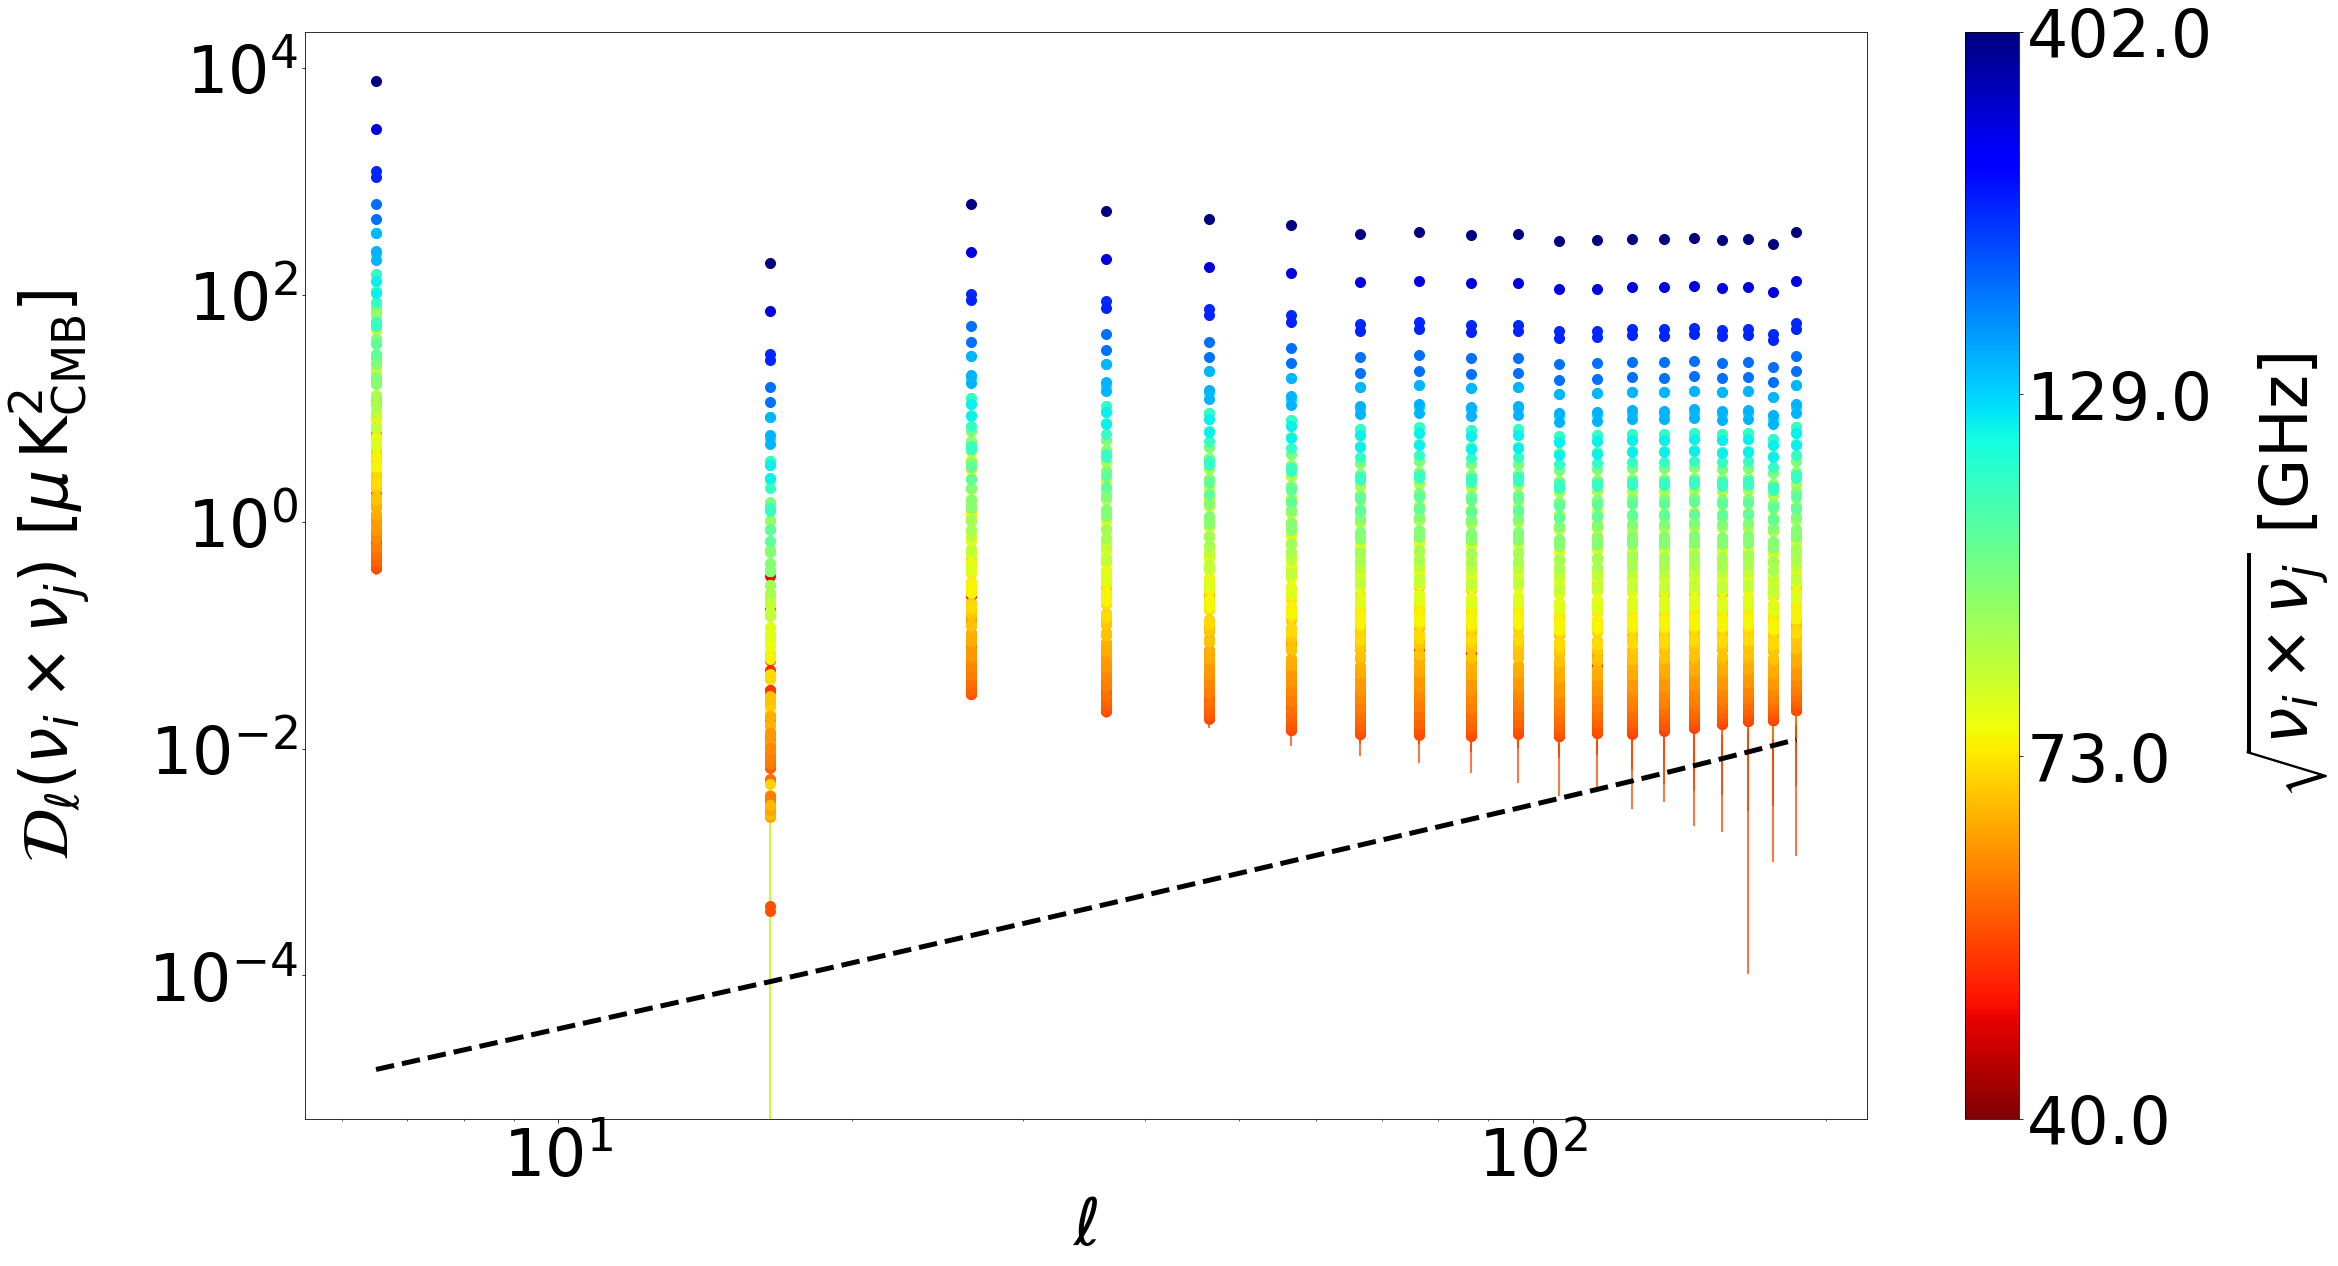

In [184]:
plotDL(DLd1s1,leff)

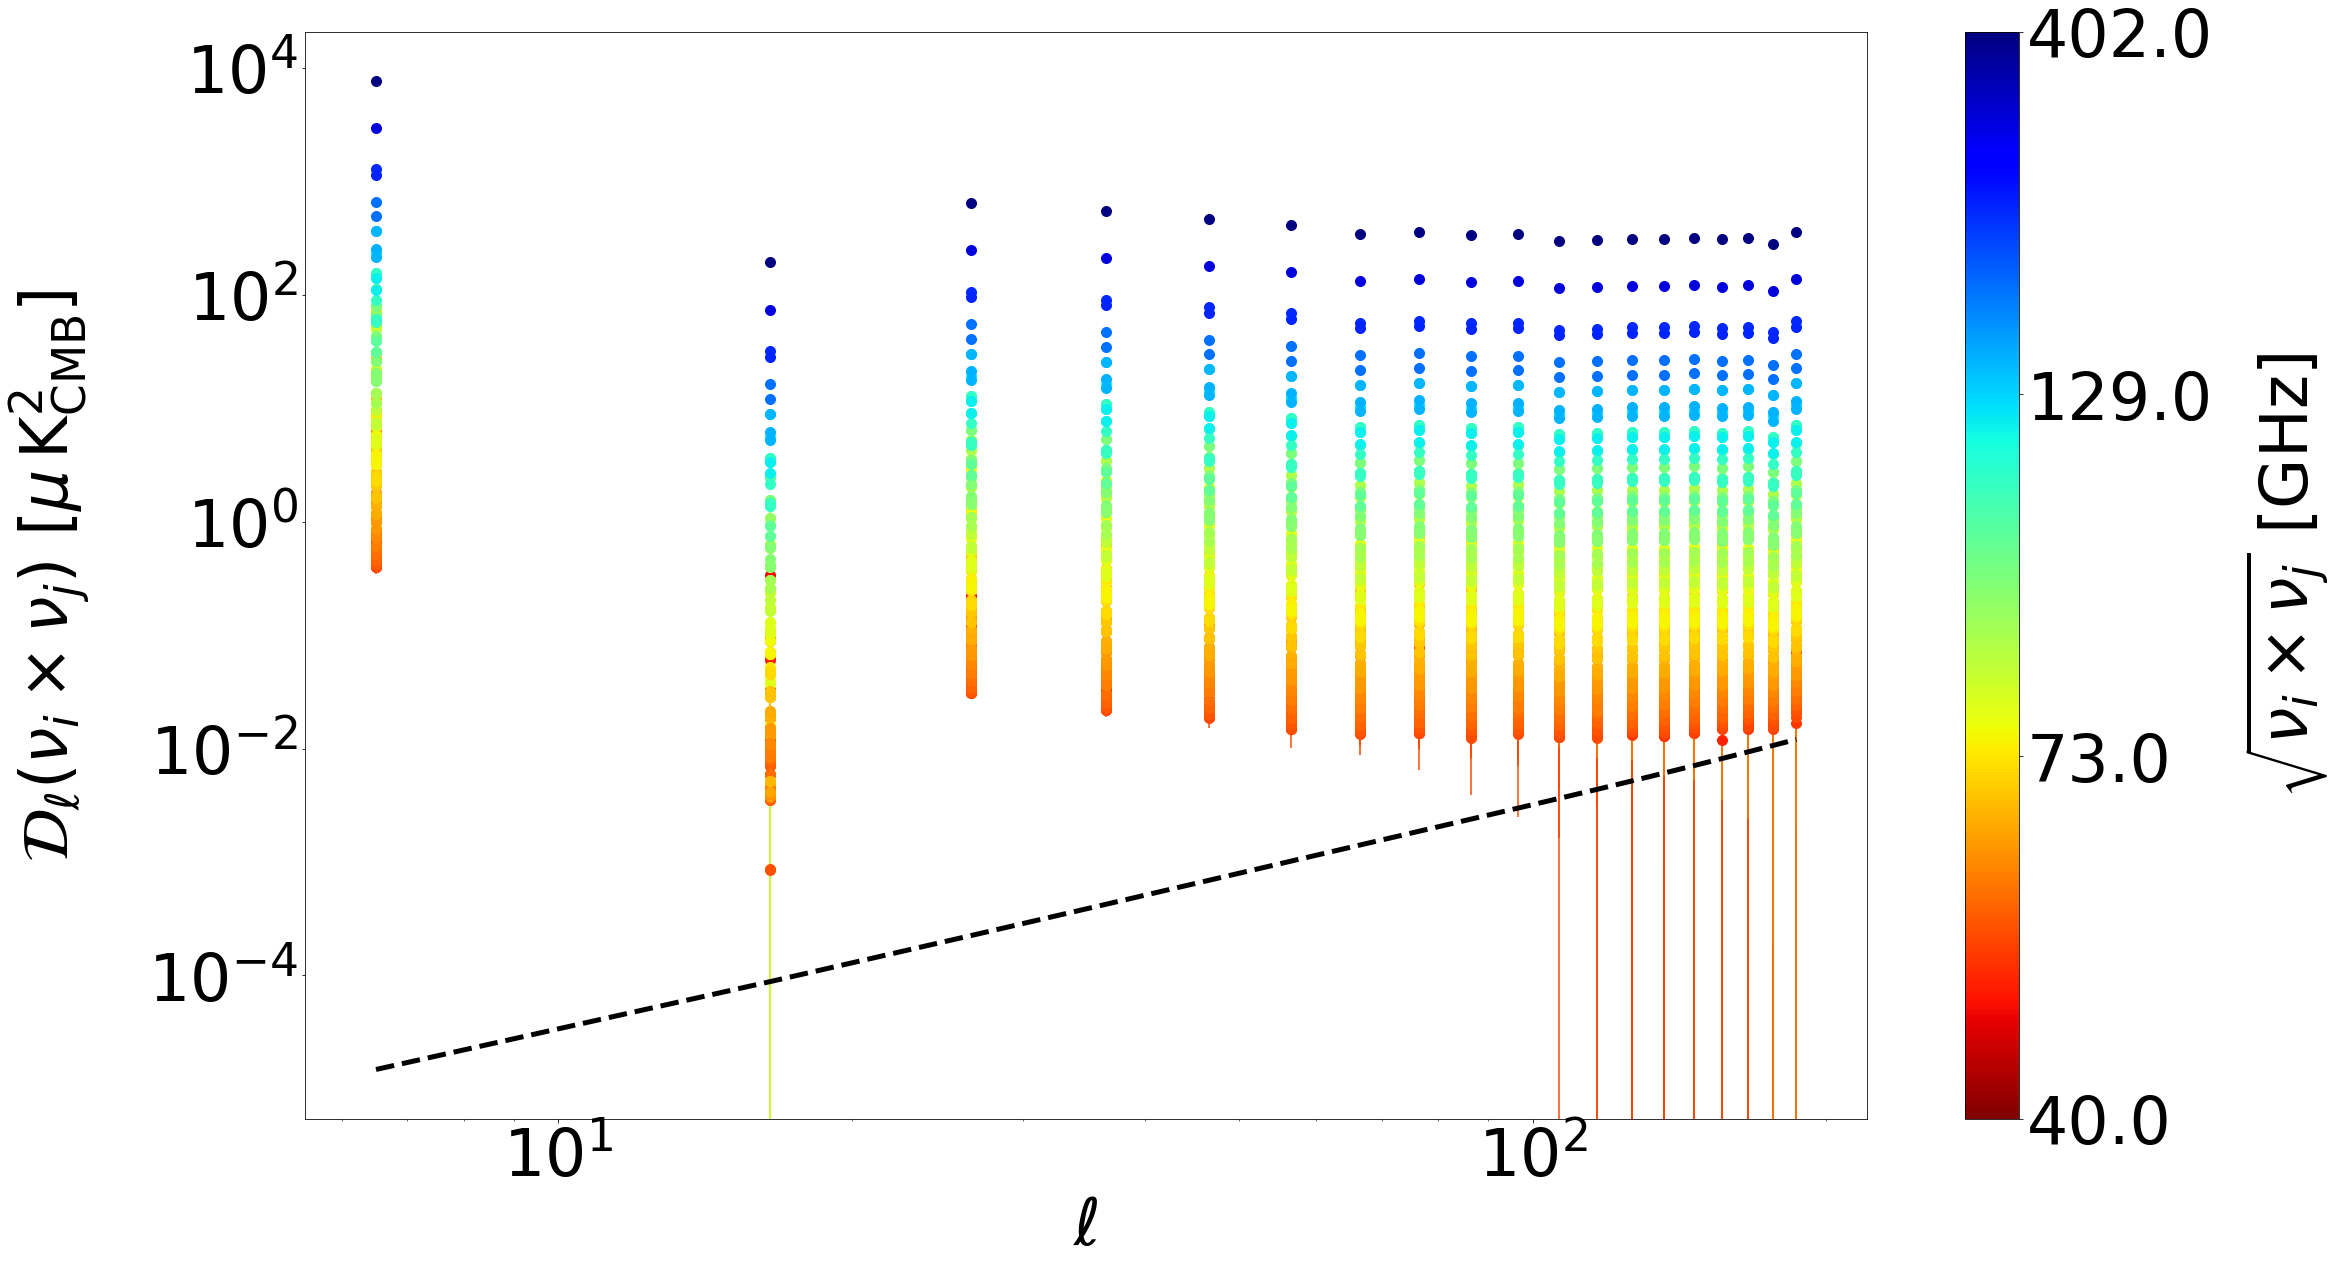

In [185]:
plotDL(DLdbsb,leff)

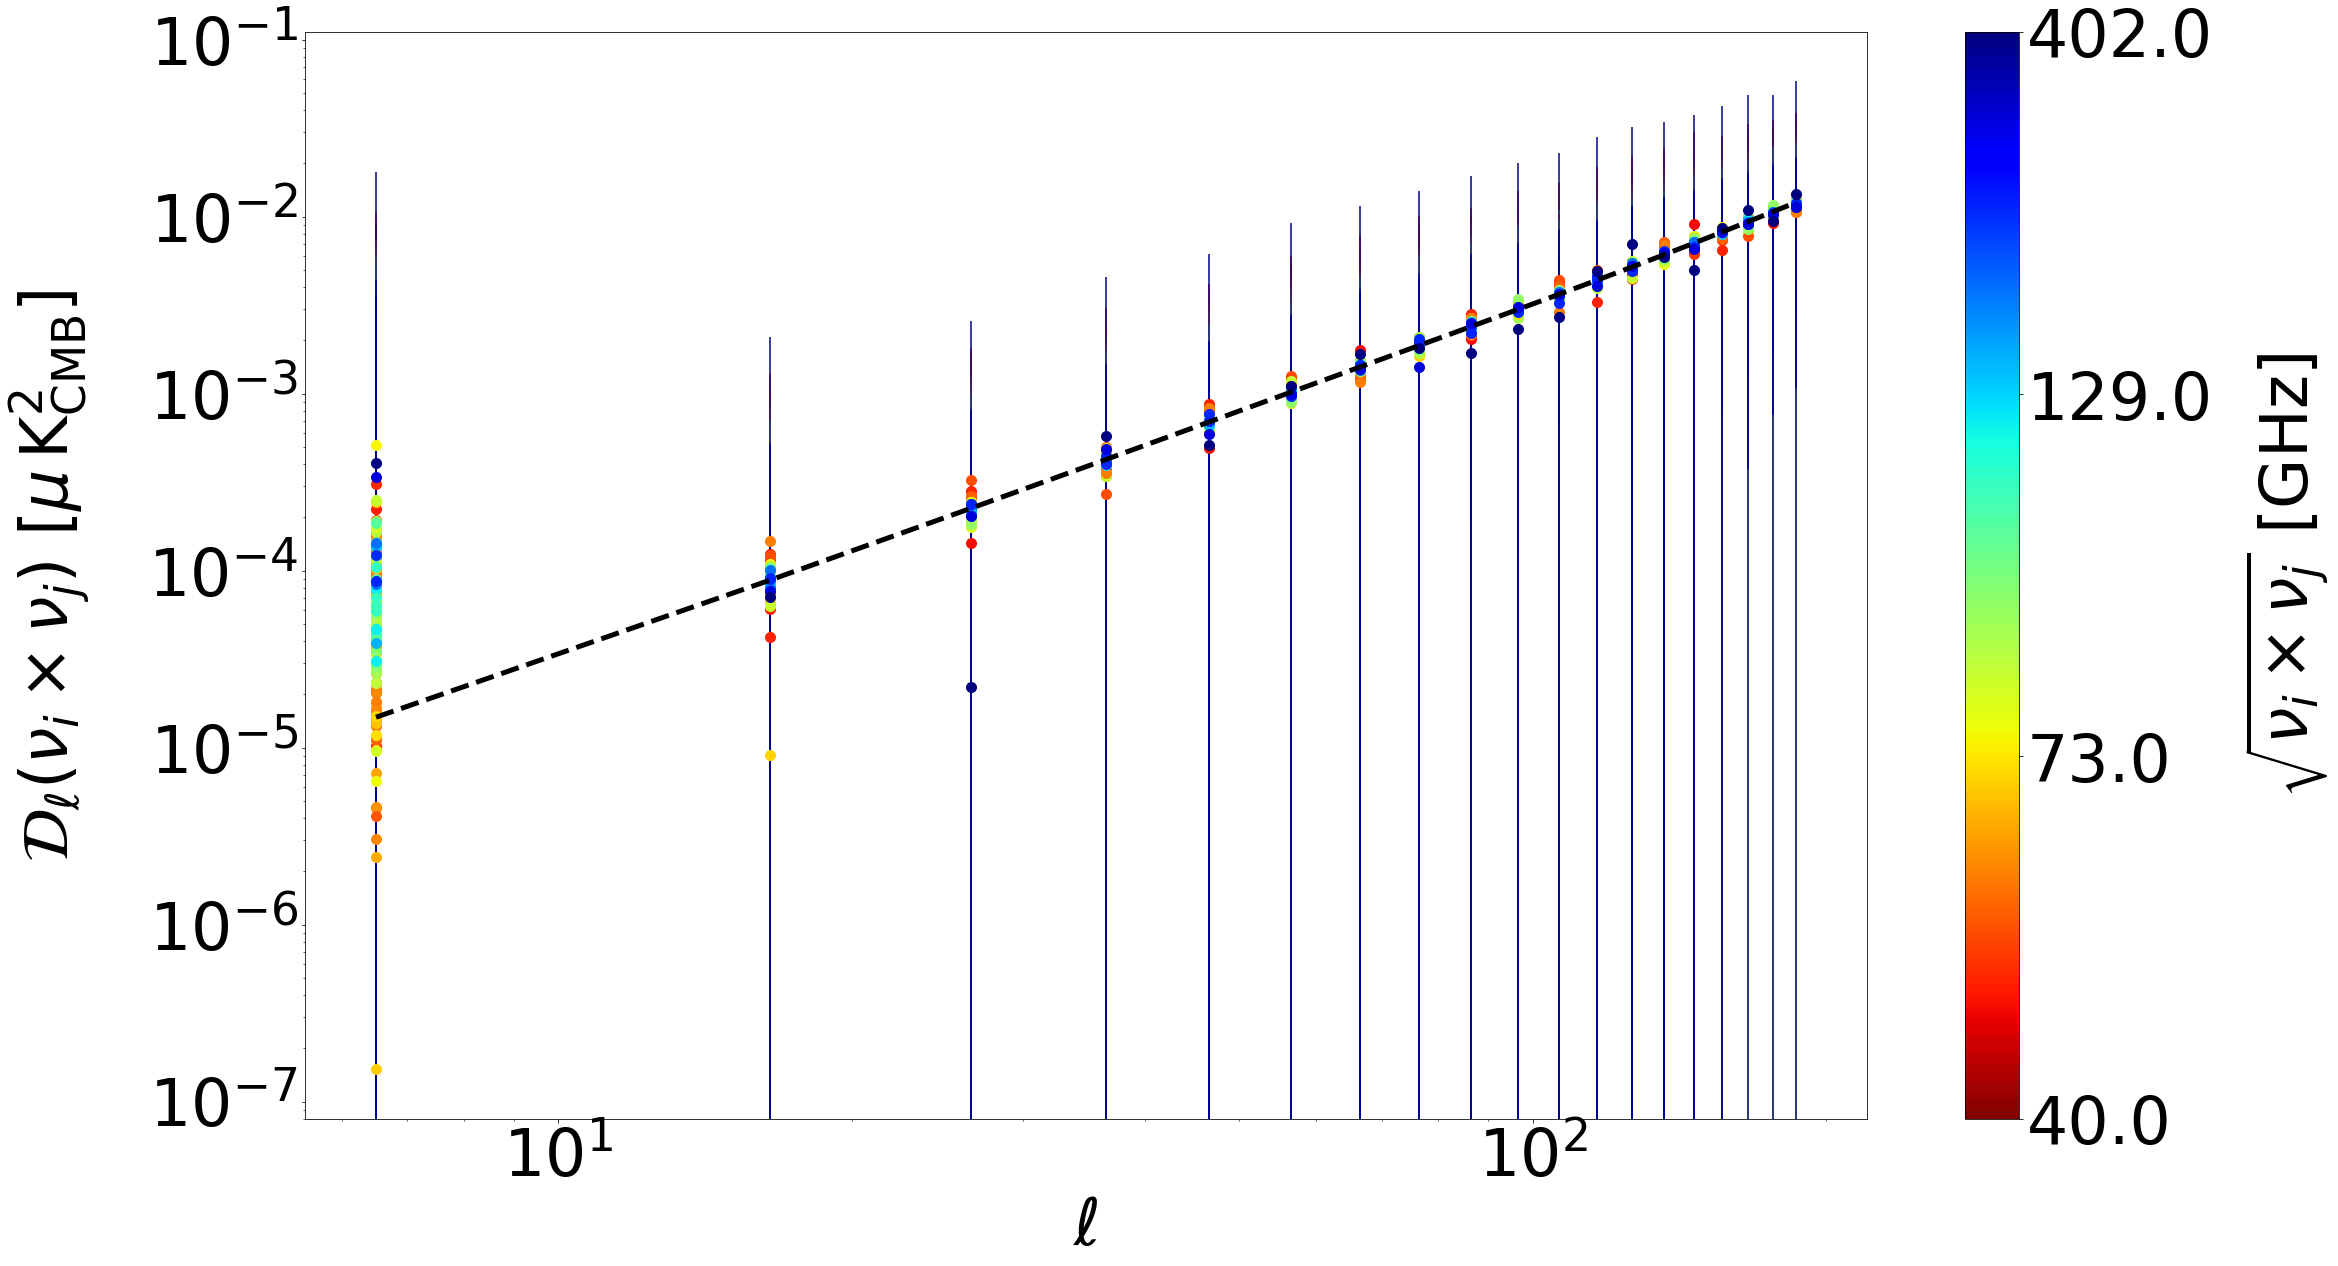

In [186]:
plotDL(DL_cmb,leff)

In [187]:
def getcov(DL,printdiag=False,offset=0):
    _,_,Nell = DL.shape
    Covdc = []
    DLtempo = np.swapaxes(DL,0,1)
    for L in range(Nell):
        cov = np.cov(DLtempo[:,:,L])
        Covdc.append(cov)
    return np.array(Covdc)

def plotcov(DL,title='',ellcov=0):
    cov = getcov(DL)
    plt.figure(figsize=(30, 30))
    plt.imshow(np.log10(abs(cov[ellcov])), cmap='viridis', aspect='auto', vmin=-13, vmax=1)  # Set color limits
    plt.colorbar(label='$\log_{10}(|\Sigma|)$')
    plt.title(title)
    plt.xlabel(r'$\sqrt{\nu_i\nu_j}$')
    plt.ylabel(r'$\sqrt{\nu_i\nu_j}$')
    plt.tight_layout()

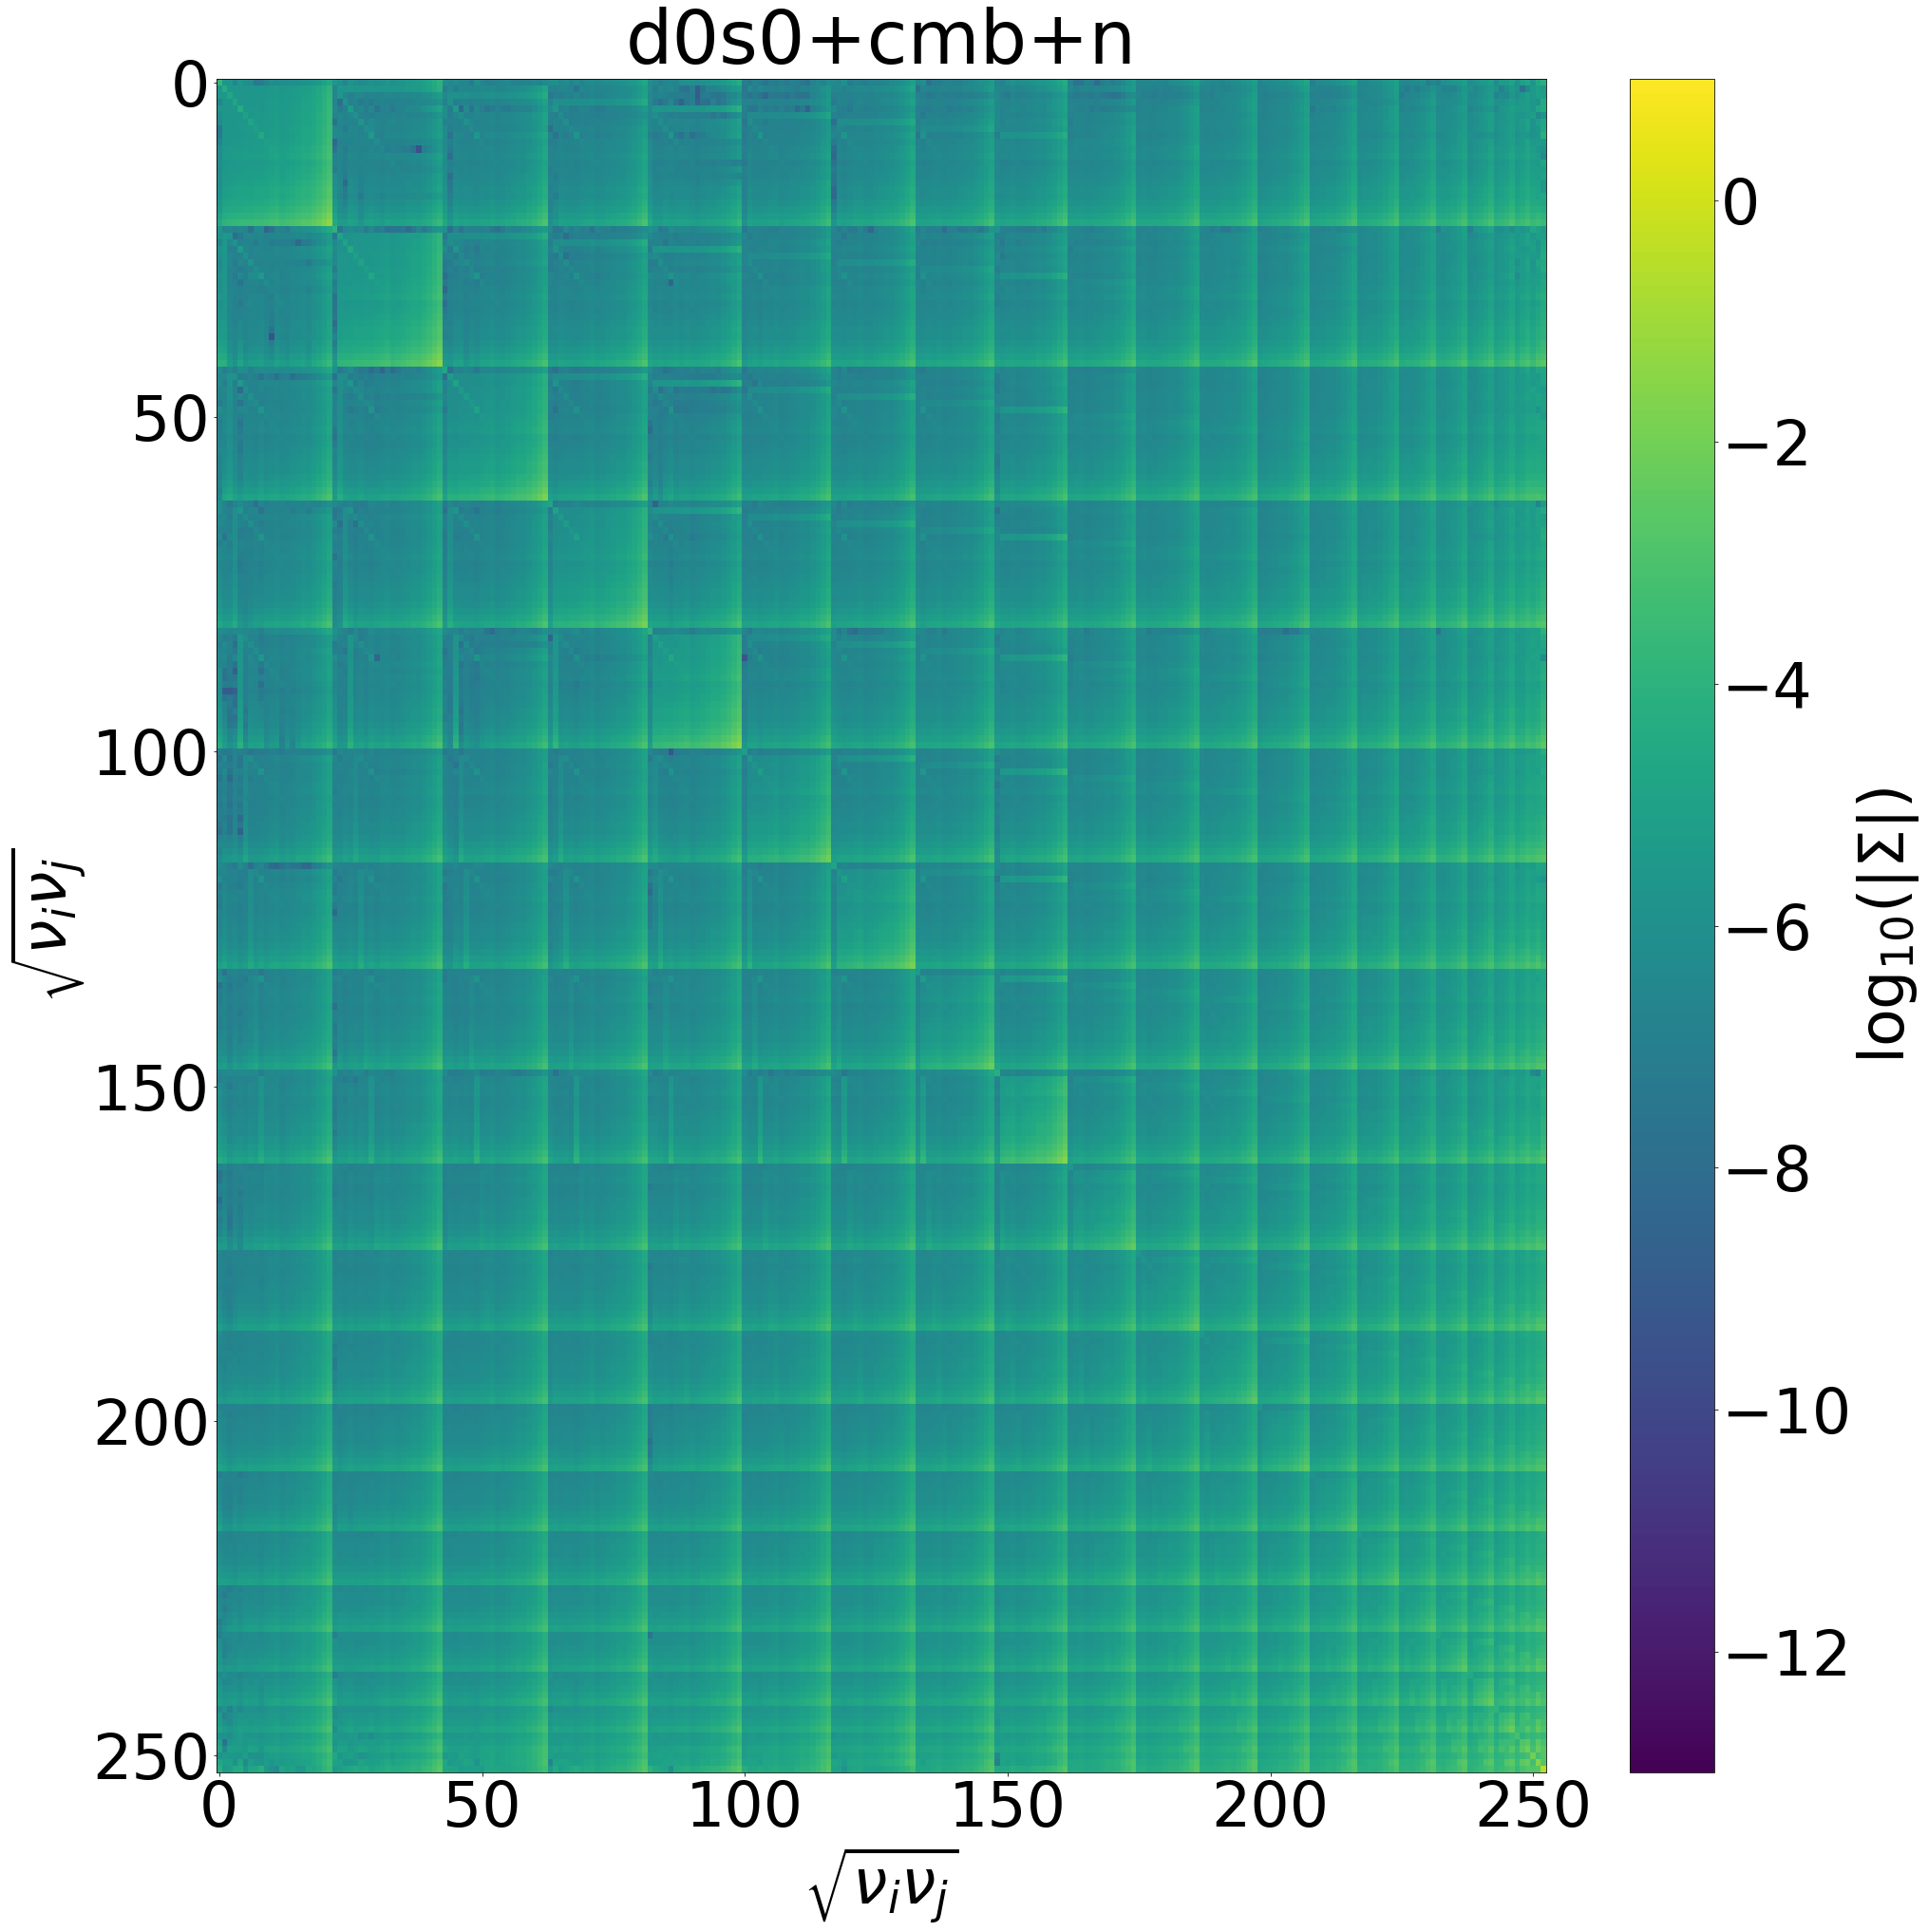

In [194]:
ellbincov=10
plotcov(DLd0s0,'d0s0+cmb+n',ellbincov)

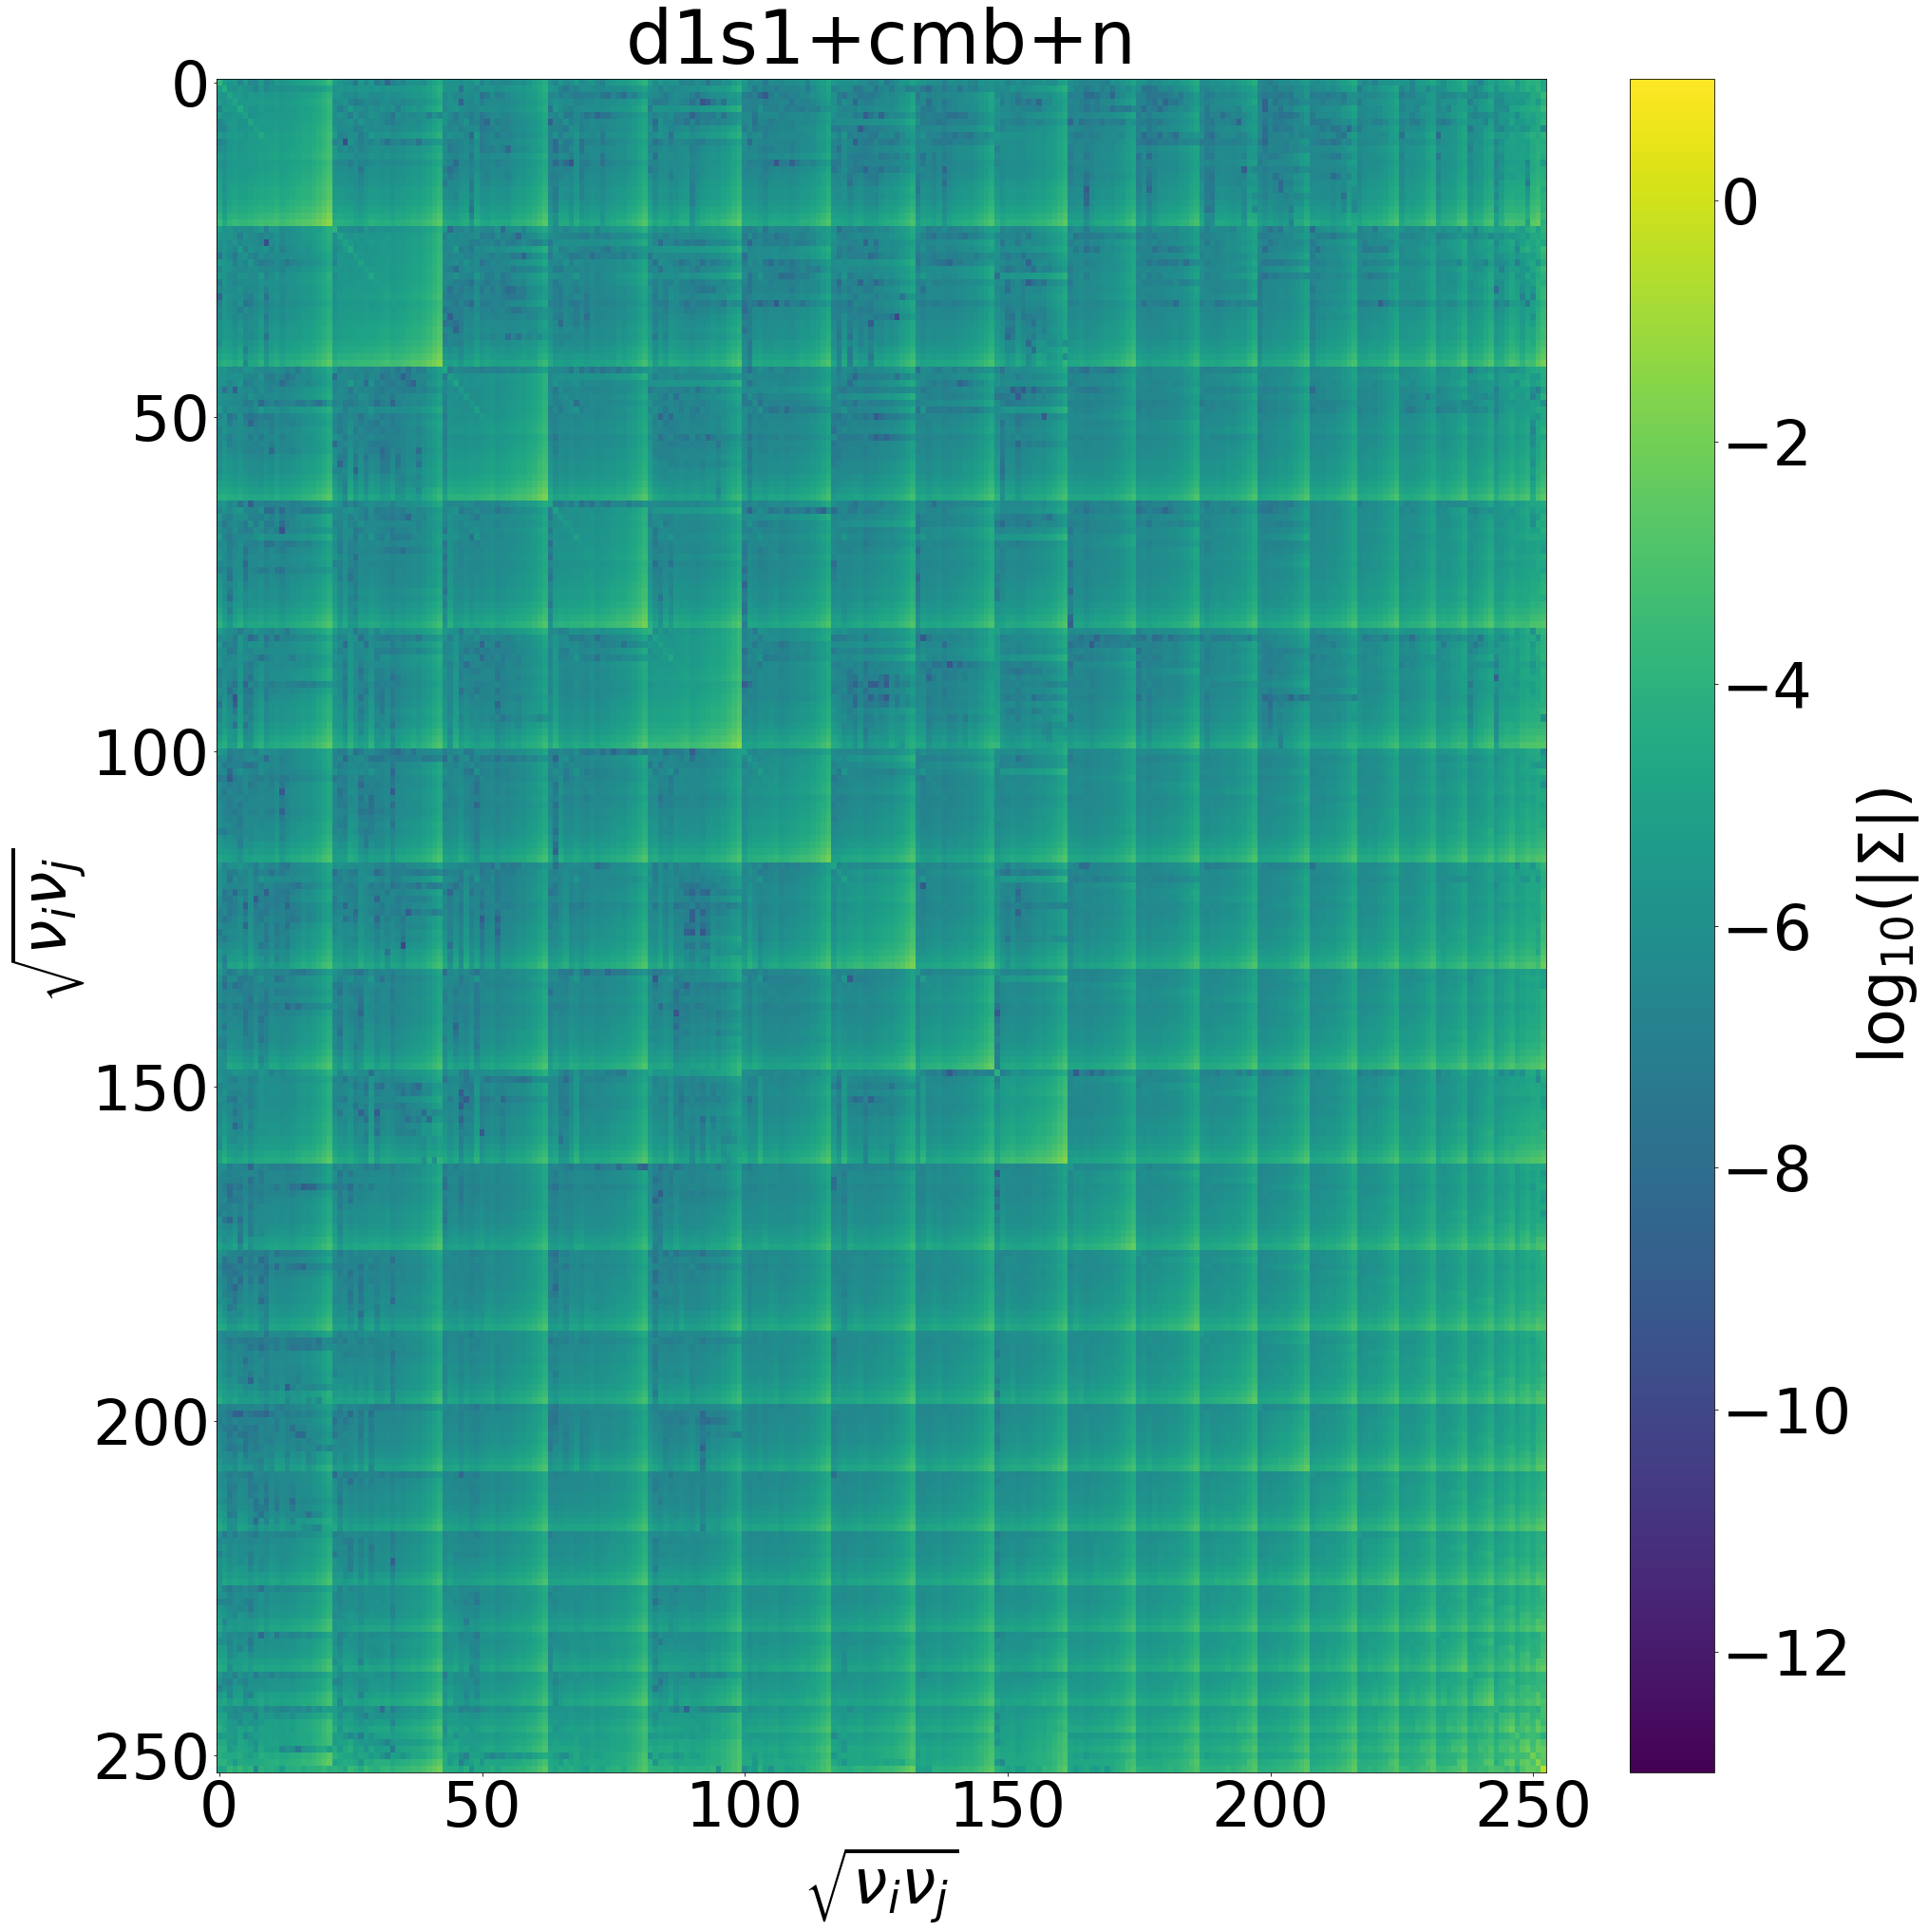

In [195]:
plotcov(DLd1s1,'d1s1+cmb+n',ellbincov)

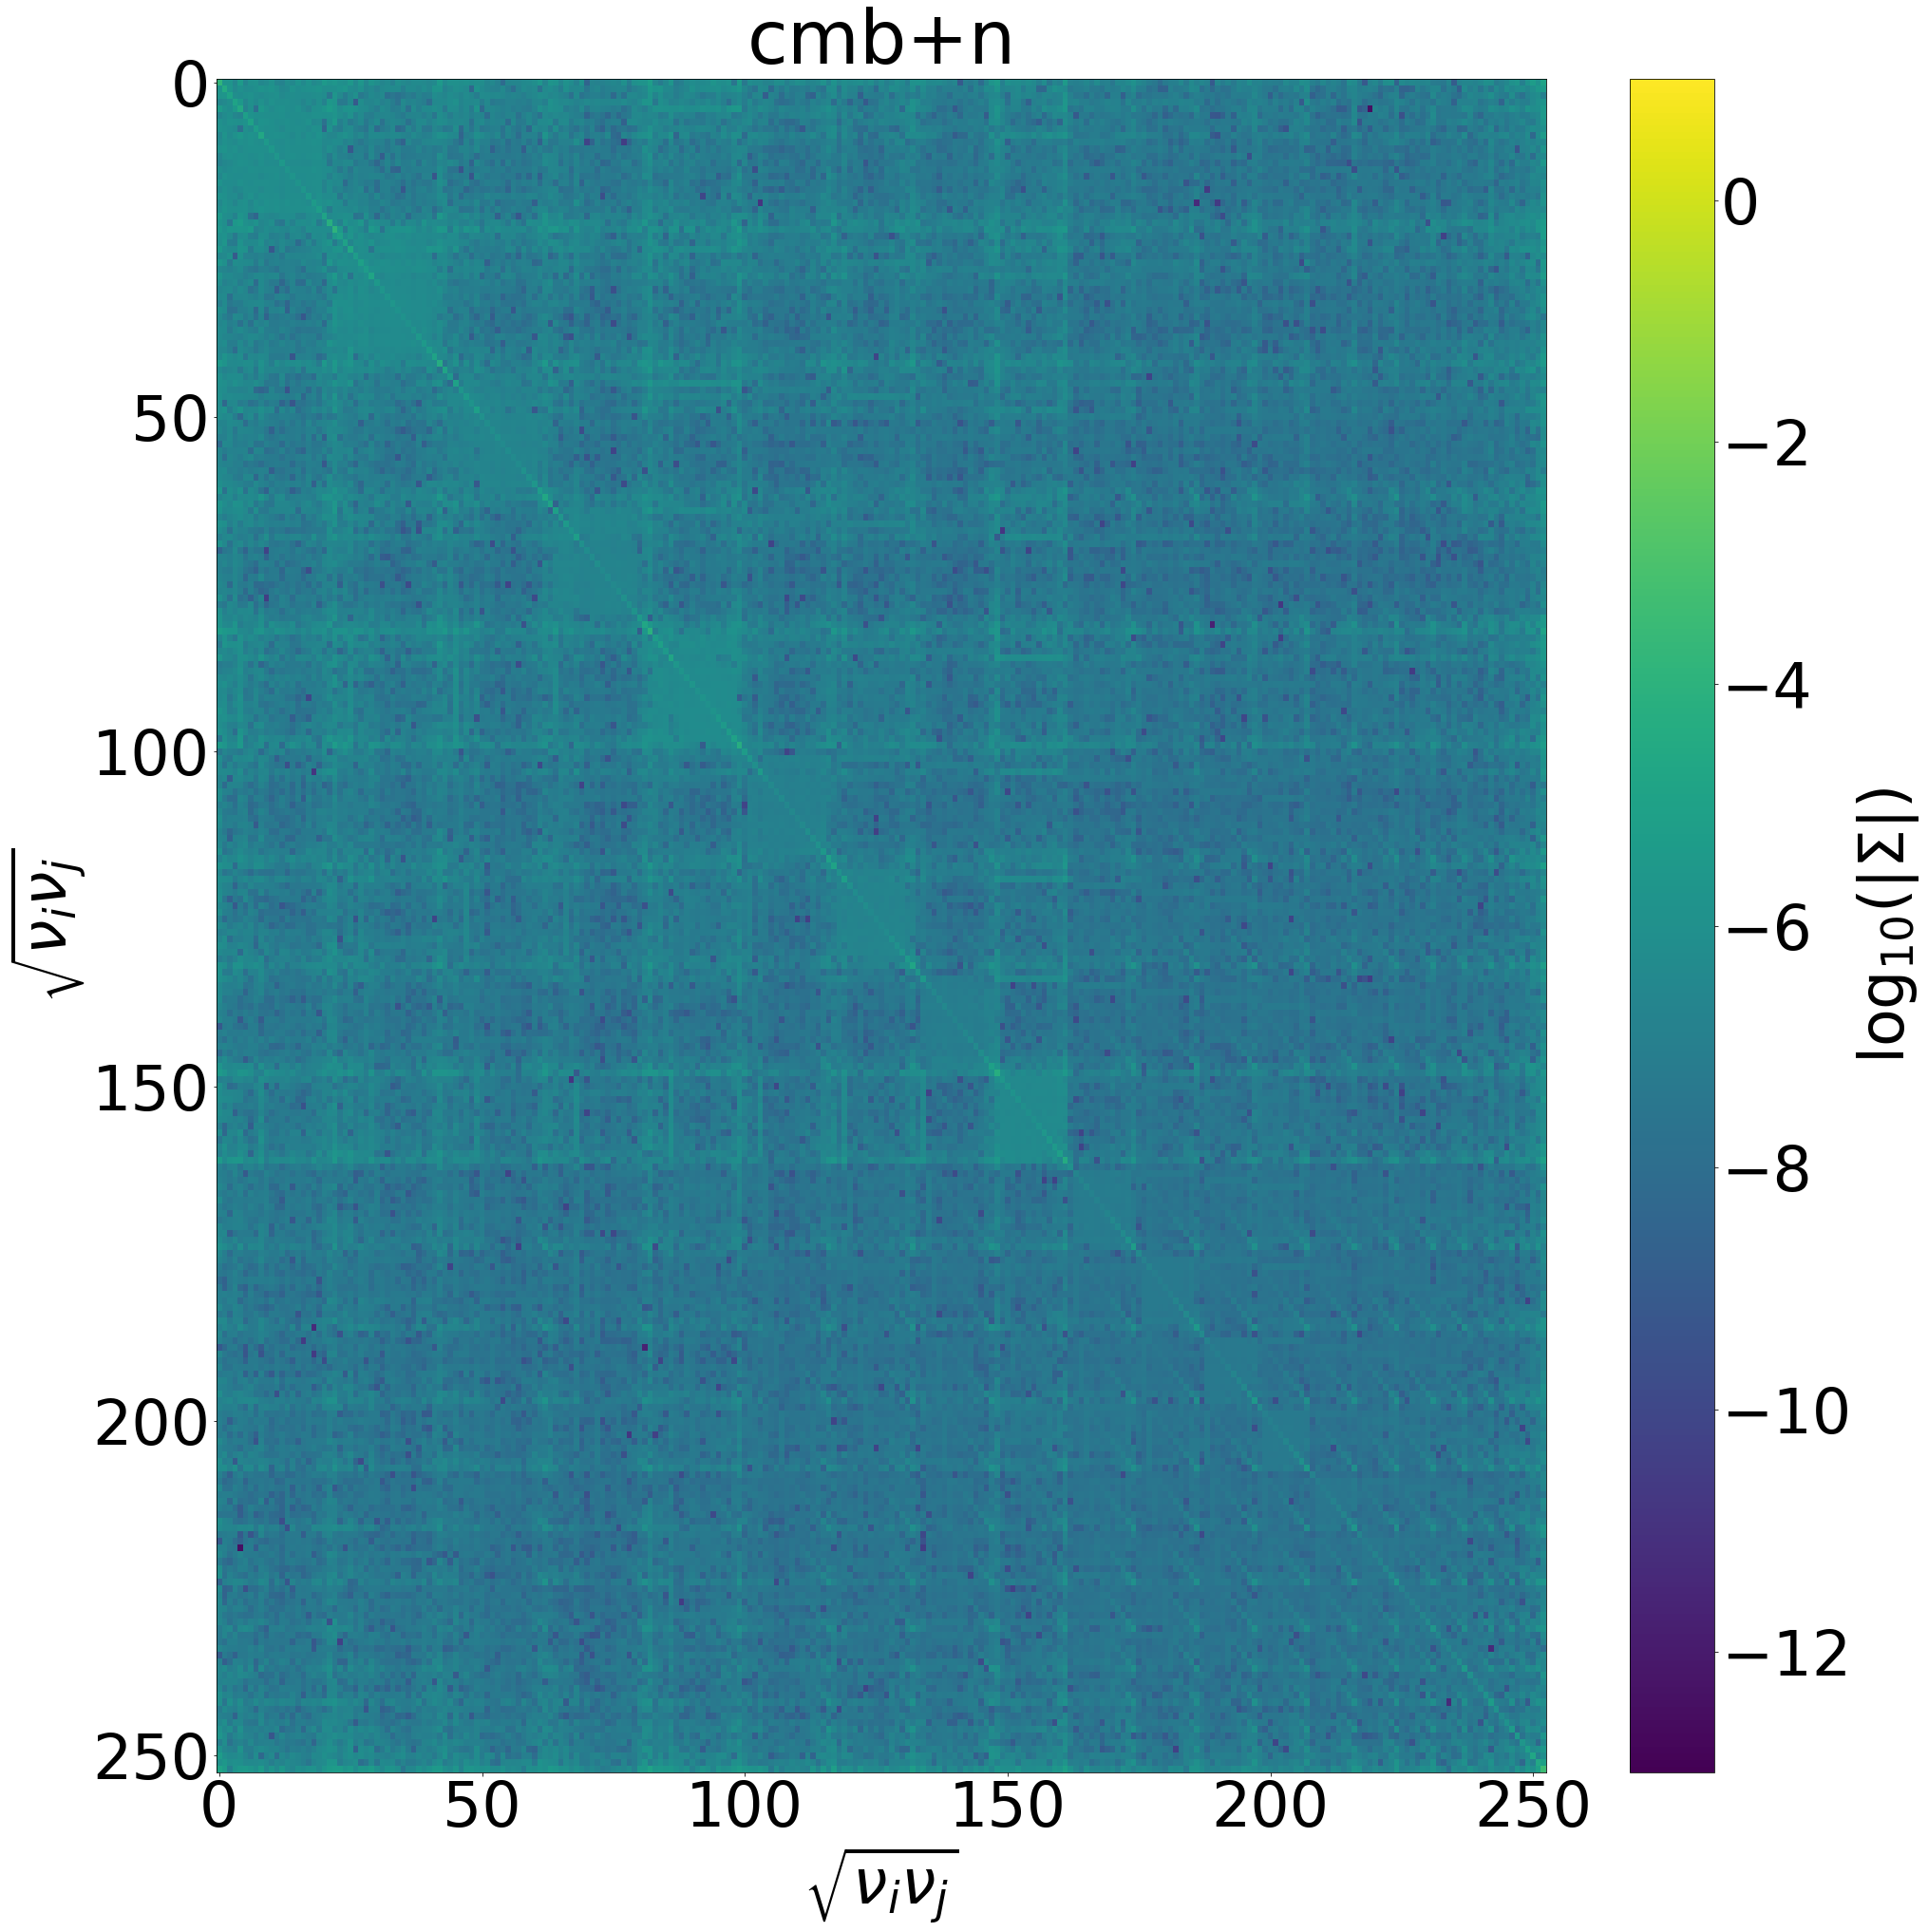

In [196]:
plotcov(DL_cmb,'cmb+n',ellbincov)

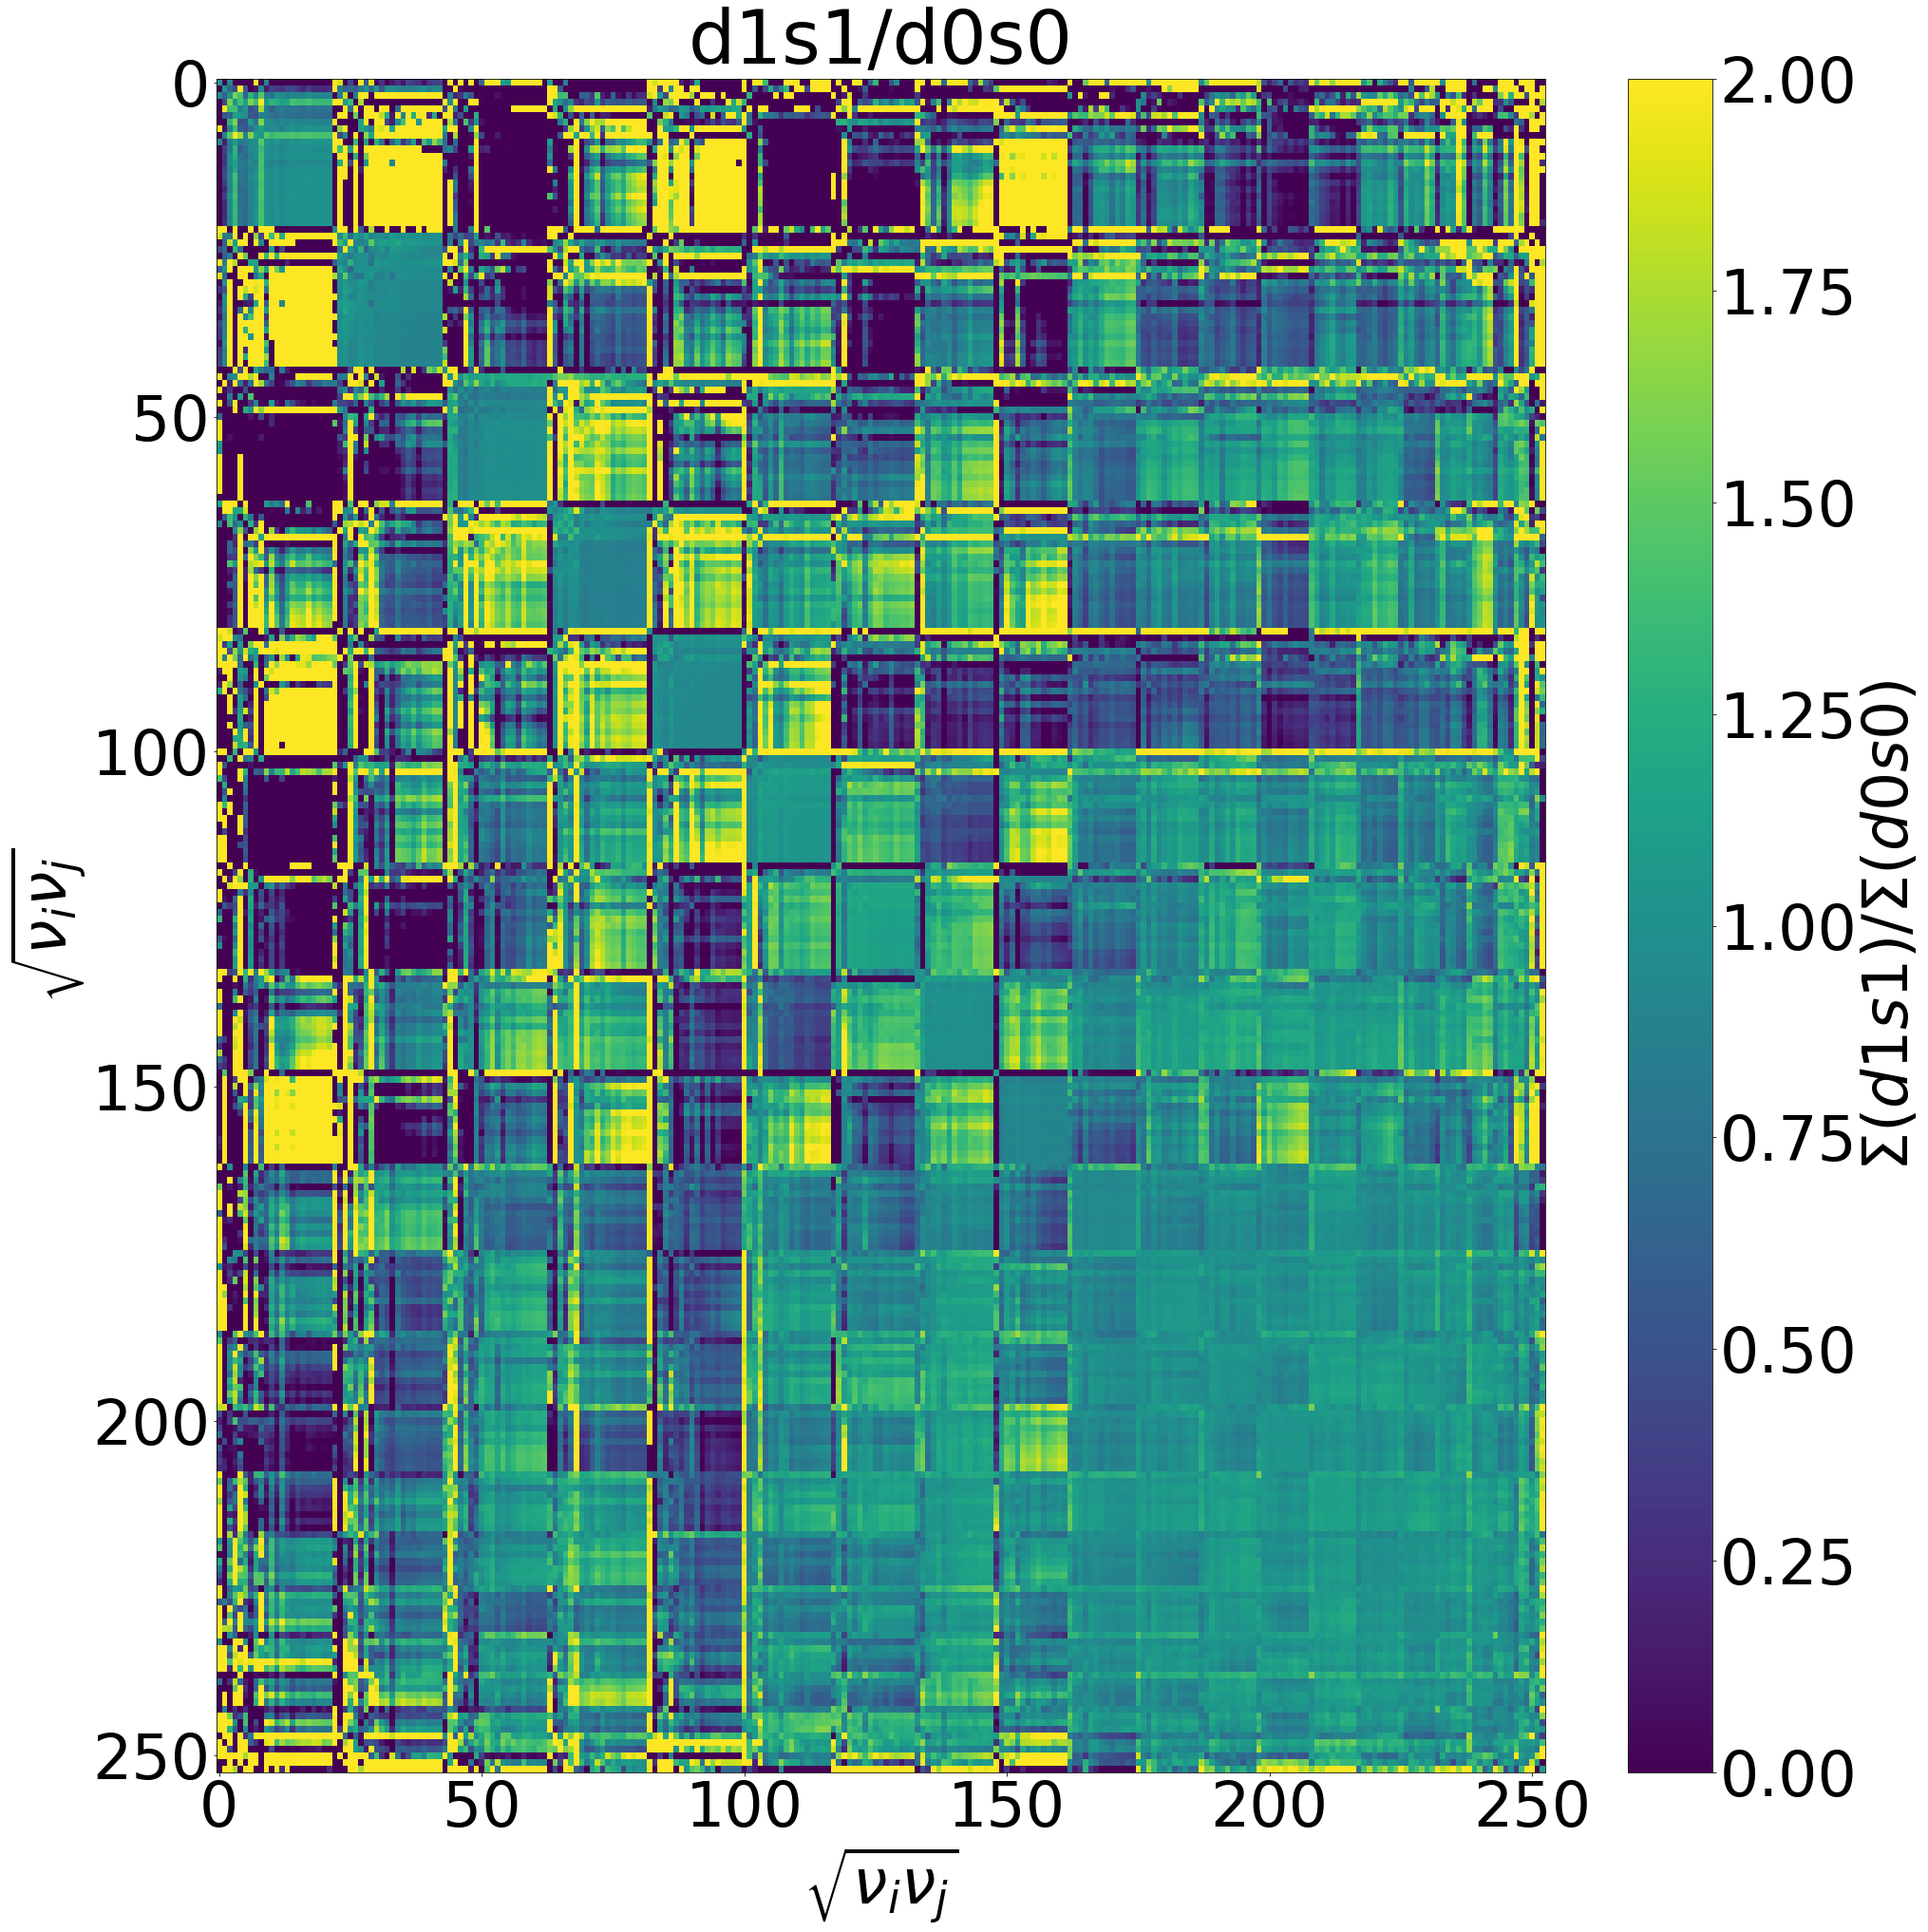

In [198]:
plt.figure(figsize=(30, 30))
plt.imshow(getcov(DLd1s1)[ellbincov]/getcov(DLd0s0)[ellbincov], cmap='viridis', aspect='auto', vmin=0, vmax=2)  # Set color limits
plt.colorbar(label='$\Sigma(d1s1)/\Sigma(d0s0)$')
plt.title('d1s1/d0s0')
plt.xlabel(r'$\sqrt{\nu_i\nu_j}$')
plt.ylabel(r'$\sqrt{\nu_i\nu_j}$')
plt.tight_layout()

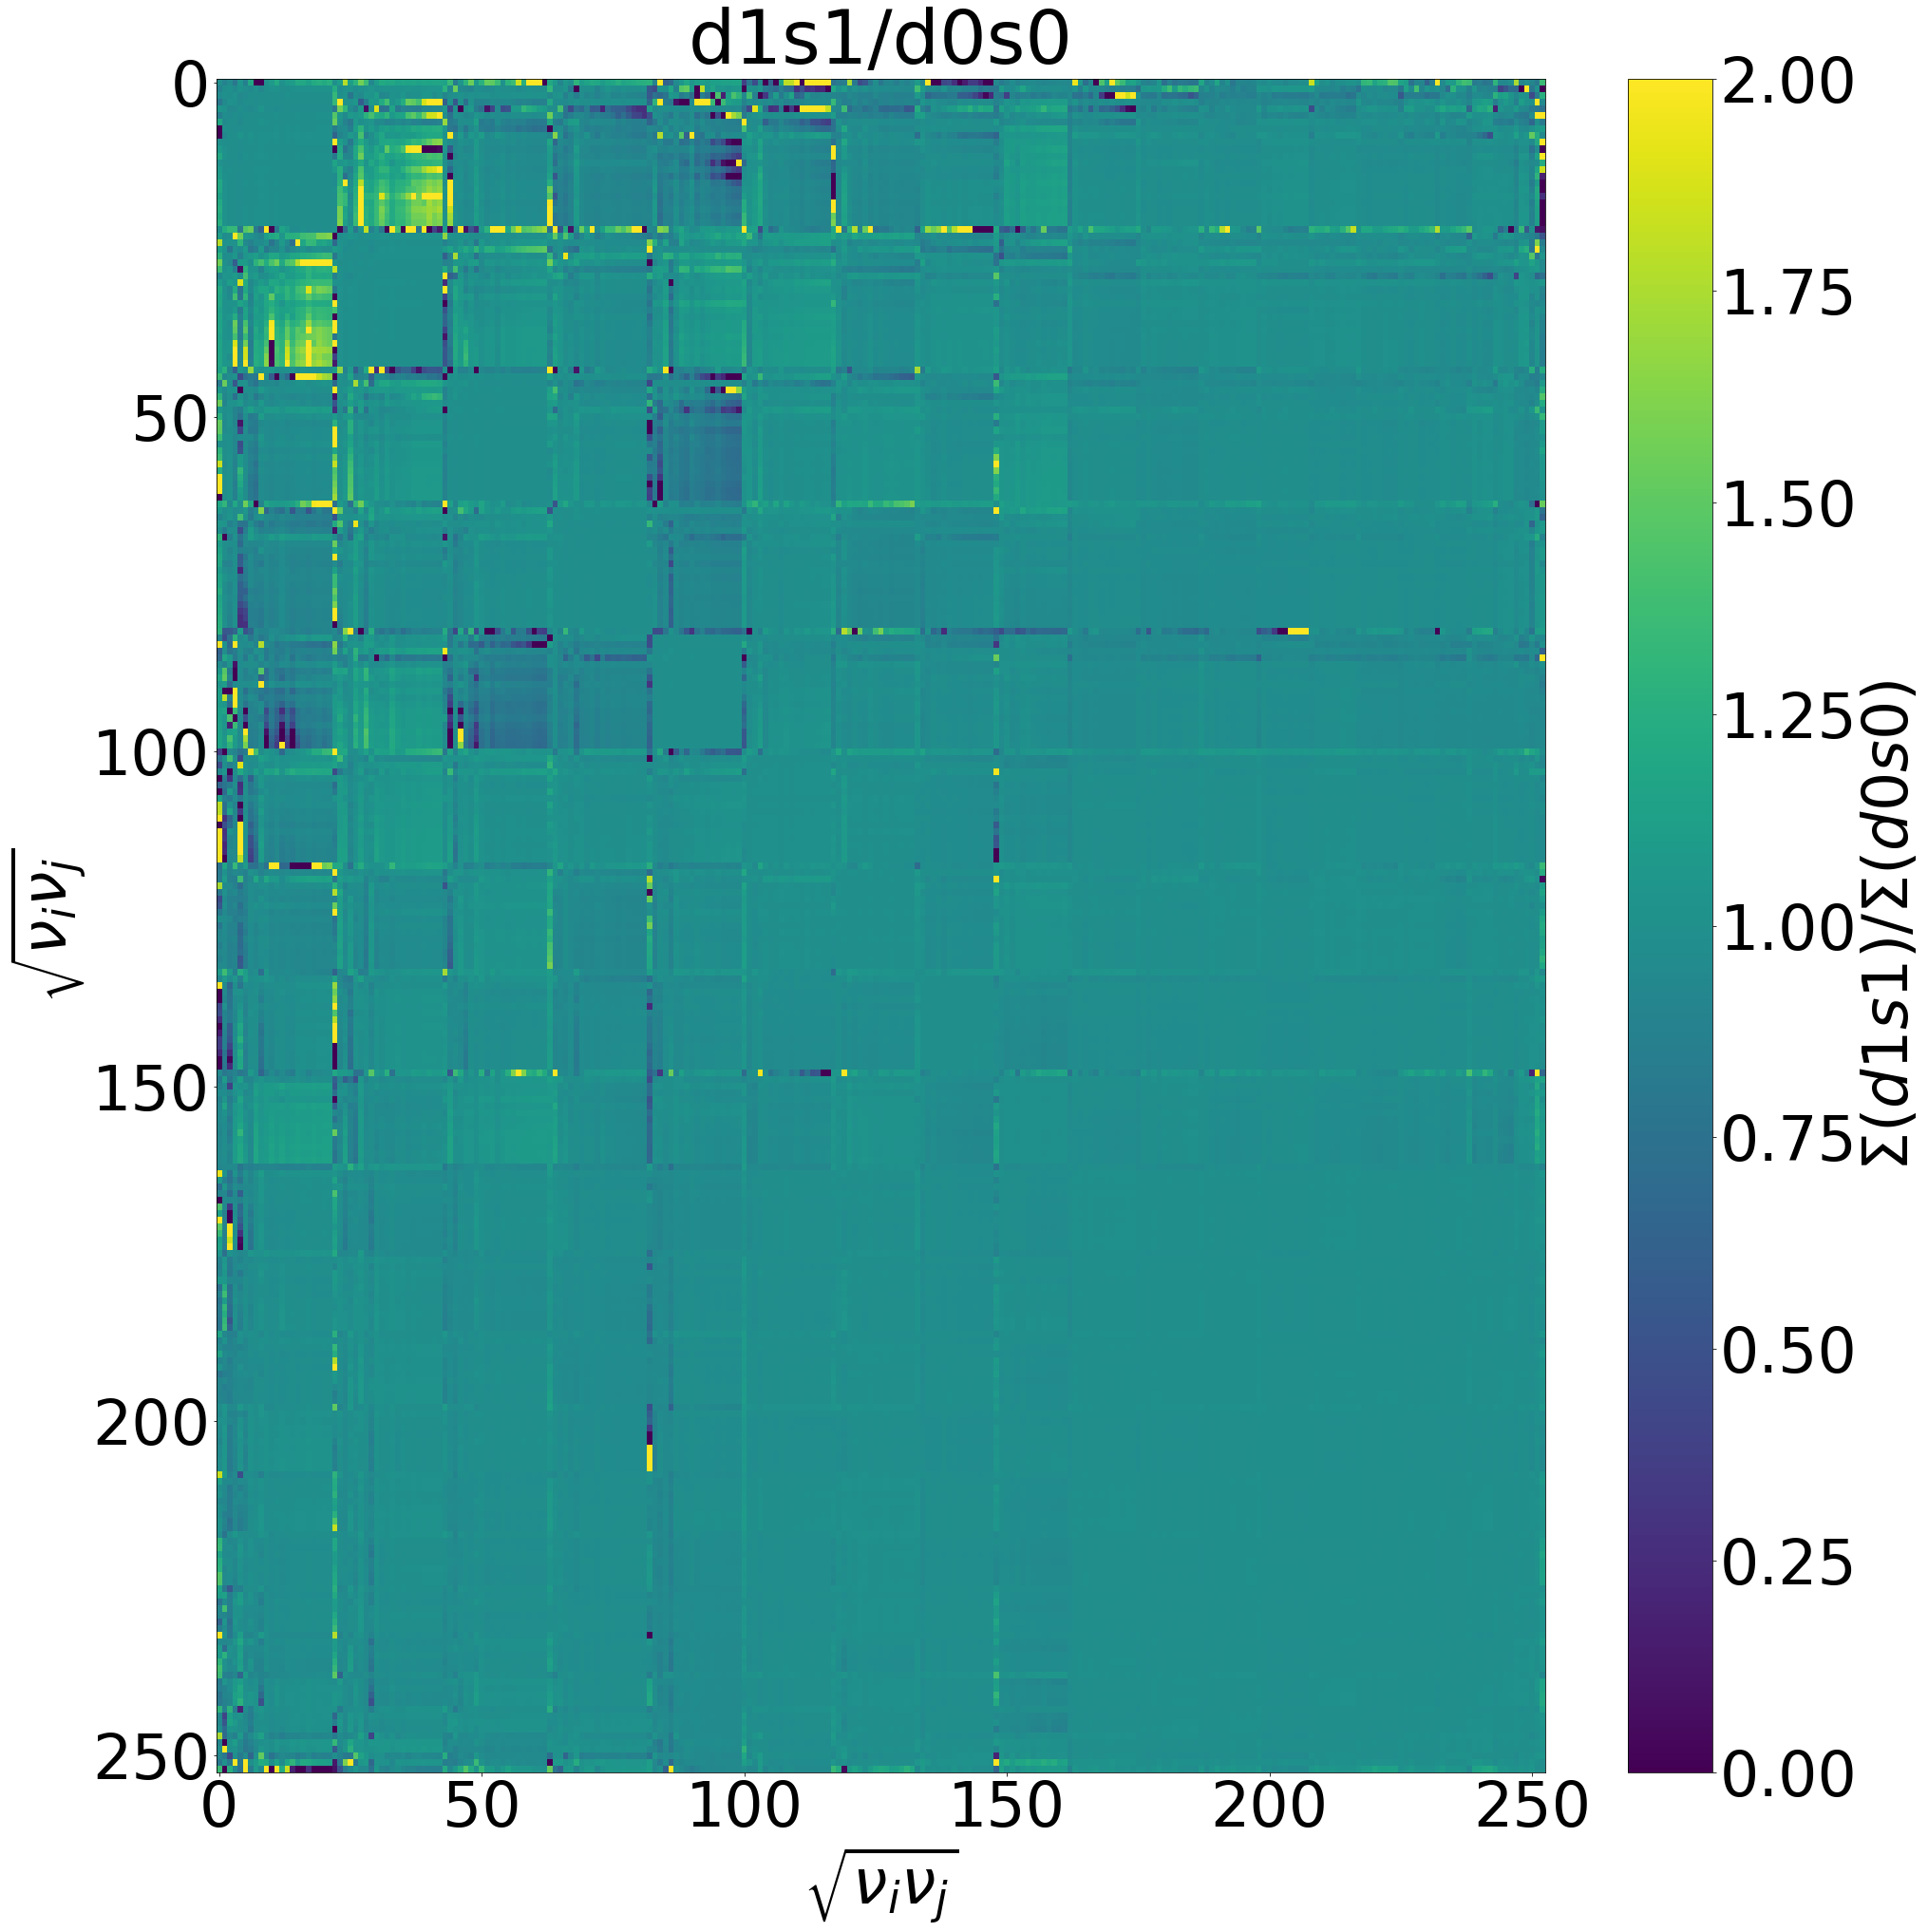

In [208]:
plt.figure(figsize=(30, 30))
plt.imshow(getcov(DLd0s0[500:])[ellbincov]/getcov(DLd0s0)[ellbincov], cmap='viridis', aspect='auto', vmin=0, vmax=2)  # Set color limits
plt.colorbar(label='$\Sigma(d1s1)/\Sigma(d0s0)$')
plt.title('d1s1/d0s0')
plt.xlabel(r'$\sqrt{\nu_i\nu_j}$')
plt.ylabel(r'$\sqrt{\nu_i\nu_j}$')
plt.tight_layout()